# Download requirements

In [ ]:
install.packages('fpp2')

In [1]:
library(fpp2)

Warning message:
"package 'fpp2' was built under R version 3.6.3"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
-- Attaching packages ---------------------------------------------- fpp2 2.4 --
v ggplot2   3.1.1     v fma       2.4  
v forecast  8.14      v expsmooth 2.3  
Warning message:
"package 'forecast' was built under R version 3.6.3"Warning message:
"package 'fma' was built under R version 3.6.3"Warning message:
"package 'expsmooth' was built under R version 3.6.3"


# Load dataset

In [2]:
data <- read.csv('Data.csv')

In [3]:
summary(data)

      Date            Mkt.RF              SMB                HML         
 Min.   :196307   Min.   :-23.2400   Min.   :-15.3900   Min.   :-13.920  
 1st Qu.:197803   1st Qu.: -1.9600   1st Qu.: -1.5400   1st Qu.: -1.395  
 Median :199212   Median :  0.9250   Median :  0.1050   Median :  0.230  
 Mean   :199248   Mean   :  0.5648   Mean   :  0.2214   Mean   :  0.300  
 3rd Qu.:200708   3rd Qu.:  3.4000   3rd Qu.:  2.0650   3rd Qu.:  1.700  
 Max.   :202204   Max.   : 16.1000   Max.   : 18.3800   Max.   : 12.740  
      RMW                CMA                RF             NoDur        
 Min.   :-18.7600   Min.   :-6.7800   Min.   :0.0000   Min.   :-21.020  
 1st Qu.: -0.8175   1st Qu.:-1.0000   1st Qu.:0.1400   1st Qu.: -1.242  
 Median :  0.2400   Median : 0.1100   Median :0.3800   Median :  1.080  
 Mean   :  0.2752   Mean   : 0.2947   Mean   :0.3641   Mean   :  1.049  
 3rd Qu.:  1.2775   3rd Qu.: 1.4900   3rd Qu.:0.5100   3rd Qu.:  3.720  
 Max.   : 13.3800   Max.   : 9.0600   Max.  

# Predict cho Utils portfolio

#### Lấy dữ liệu của Utils porfolio

In [4]:
series <- ts(data = data$Utils, start = c(1963,7), end = c(2022,4), frequency = 12)

In [5]:
series %>% summary()

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-13.0100  -1.4200   0.9150   0.8424   3.2775  18.8400 

#### Khảo sát tập train từ 7/1963 - 12/1989

In [6]:
log_scale <- function(x) {log(1+x/100)} #scaler
log_inv <- function(x) {(exp(x)-1)*100} #inverter

In [7]:
series_train <- series %>% window(end=c(1989,12)) %>% log_scale

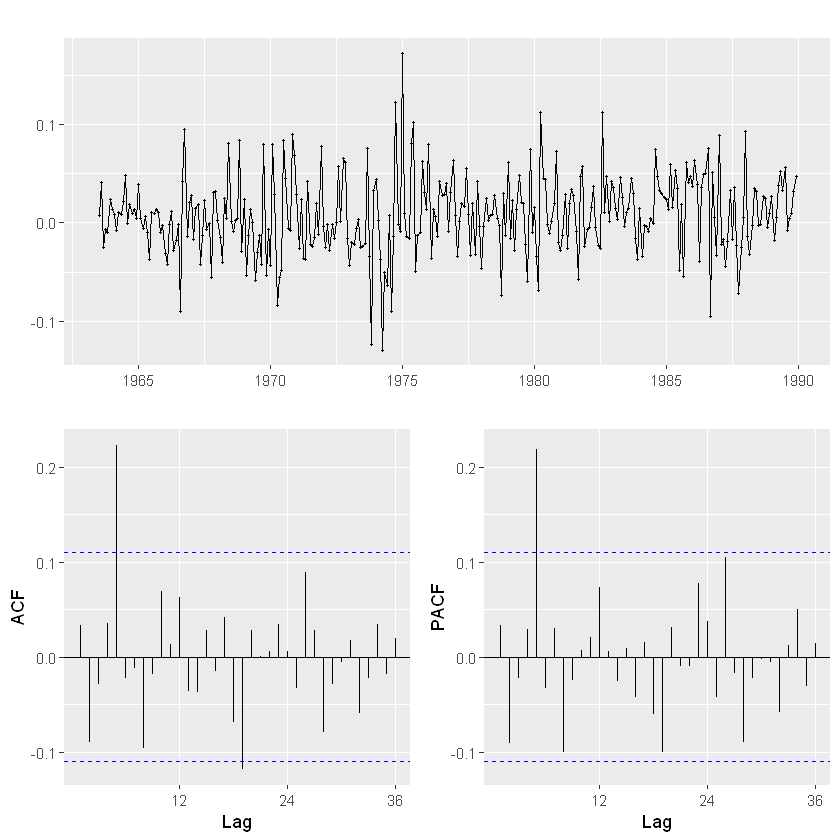

In [8]:
series_train %>% ggtsdisplay()

Biểu đồ dao động không có trend và seasonality quan sát được, nên không cần lấy difference và seasonal difference. <br>
Thử lại với hàm dò tìm bậc d: ndiffs cho order và nsdiffs cho seasonal.

In [9]:
series_train %>% ndiffs()

[1] 1

In [10]:
series_train %>% nsdiffs()

[1] 0

Kết quả d = 0 cho cả order và seasonal.

#### Phân tích p và q cho mô hình ARIMA

Thử dò tìm (p,d,q) với chế độ auto theo thuật toán Hyndman-Khandakar.

In [11]:
fit <- auto.arima(series_train, stepwise = FALSE, approximation = FALSE)
fit

Series: series_train 
ARIMA(1,1,2) 

Coefficients:
          ar1      ma1      ma2
      -0.7969  -0.1155  -0.8605
s.e.   0.0993   0.0785   0.0770

sigma^2 estimated as 0.001596:  log likelihood=570.64
AIC=-1133.28   AICc=-1133.15   BIC=-1118.24


	Ljung-Box test

data:  Residuals from ARIMA(1,1,2)
Q* = 30.339, df = 21, p-value = 0.08539

Model df: 3.   Total lags used: 24



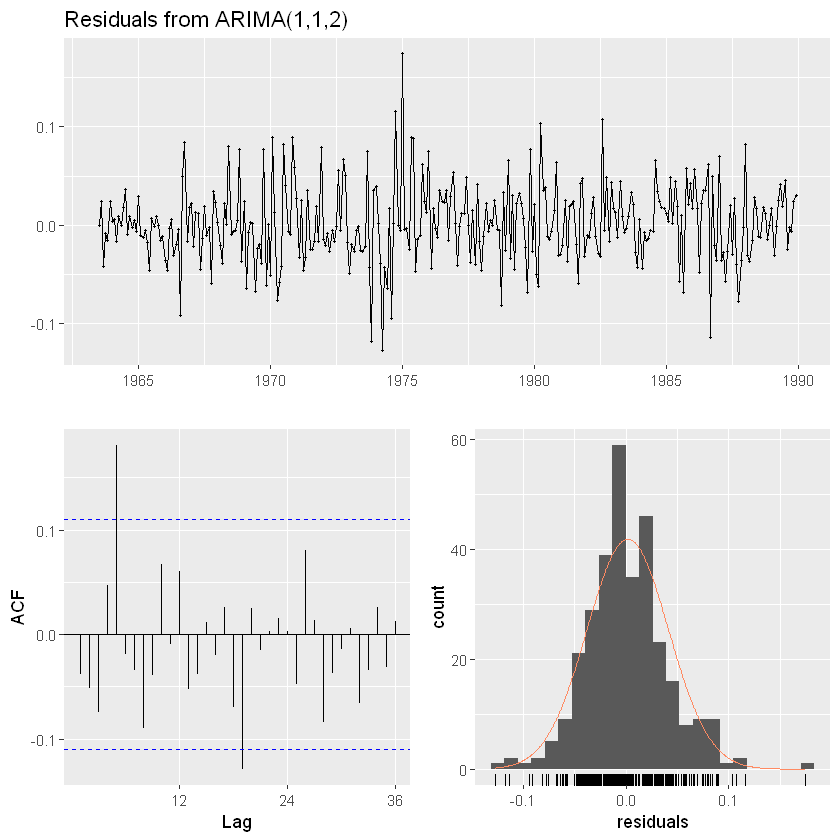

In [12]:
fit %>% checkresiduals()

Auto đề xuất ARIMA(1,1,2), Ljung-Box test cho p-value > 0.05 nên mô hình phù hợp.

Thử tất cả các mô hình đề xuất và so sánh theo tiêu chuẩn thông tin AIC, AICc, BIC, RMSE.

In [13]:
model <- list(ARIMA001 = c(0,0,1), ARIMA002 = c(0,0,2), ARIMA003 = c(0,0,3), ARIMA101 = c(1,0,1), ARIMA102 = c(1,0,2), 
              ARIMA103 = c(1,0,3), ARIMA201 = c(2,0,1), ARIMA202 = c(2,0,2), ARIMA203 = c(2,0,3),
              ARIMA011 = c(0,1,1), ARIMA012 = c(0,1,2), ARIMA013 = c(0,1,3), ARIMA111 = c(1,1,1), ARIMA112 = c(1,1,2), 
              ARIMA113 = c(1,1,3), ARIMA211 = c(2,1,1), ARIMA212 = c(2,1,2), ARIMA213 = c(2,1,3))

In [14]:
result <- NULL
for (m in model)
{
    fit <- Arima(series_train, order = m)
    fitted <- ts(data = fit$fitted, start = c(1963,7), end = c(1989,12), frequency = 12) %>% log_inv
    rmse <- sqrt(mean((log_inv(series_train) - fitted)^2))
    result <- rbind(result, c(AIC = fit$aic, AICc = fit$aicc, BIC = fit$bic, RMSE = rmse))
}
row.names(result) <- names(model)
result

,AIC,AICc,BIC,RMSE
ARIMA001,-1139.464,-1139.388,-1128.178,4.048924
ARIMA002,-1139.869,-1139.741,-1124.820,4.032500
ARIMA003,-1137.903,-1137.711,-1119.093,4.032161
ARIMA101,-1142.050,-1141.922,-1127.002,4.019093
ARIMA102,-1140.567,-1140.374,-1121.756,4.015052
ARIMA103,-1138.139,-1137.869,-1115.567,4.019365
ARIMA201,-1138.077,-1137.885,-1119.267,4.031248
ARIMA202,-1144.556,-1144.286,-1121.983,3.977706
ARIMA203,-1144.246,-1143.884,-1117.911,3.966794
ARIMA011,-1132.442,-1132.404,-1124.924,4.059947


Mô hình ARIMA(2,0,3) cho kết quả RMSE thấp nhất trên tập train.

#### Đánh giá mô hình ARIMA(2,0,3) trên tập test

In [7]:
pred <- NULL
for (i in 0:387)
{
    train <- series %>% subset(end = length(series)-388+i) %>% log_scale
    fit <- Arima(train, order = c(2,0,3))
    pred <- c(pred, forecast(fit, h = 1)$mean %>% log_inv) 
}
pred <- ts(data = pred, start = c(1990,1), frequency = 12)
true <- series %>% window(start = c(1990,1))
rmse <- sqrt(mean((true-pred)^2))
rmse

[1] 4.020058

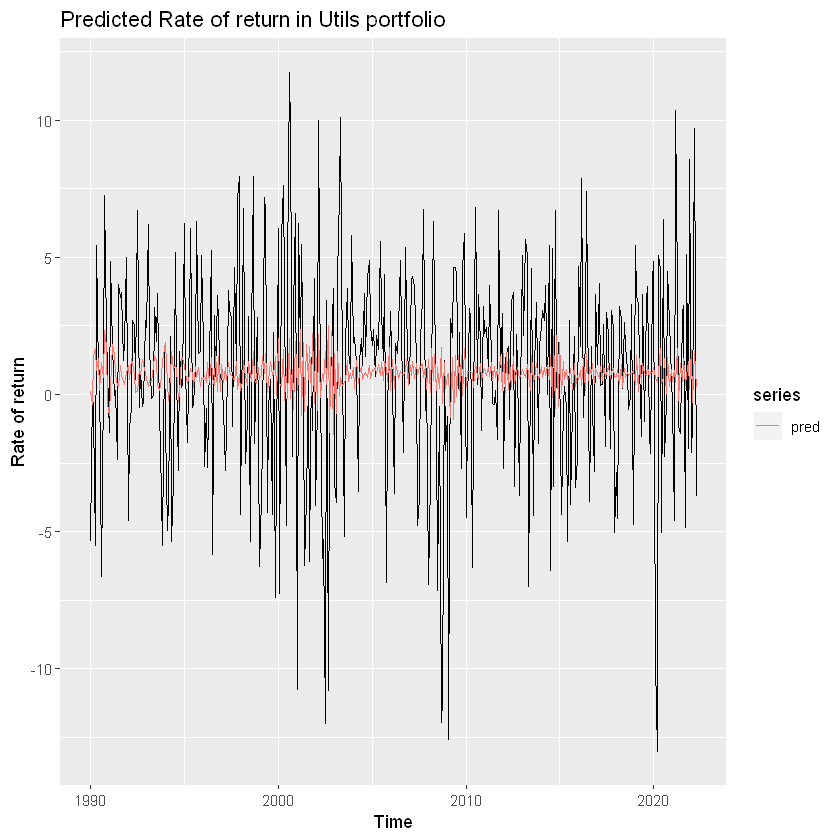

In [8]:
autoplot(true) + autolayer(pred) + labs(y = "Rate of return", title = "Predicted Rate of return in Utils portfolio")

In [9]:
as.numeric(pred)

[1]  0.10649002 -0.38105075  1.37614821  1.68420063  0.86588209  1.31240292
  [7]  0.14668823  1.16178208  0.62479271  2.31909433  1.76859123 -0.33734995
 [13] -0.77052039  0.24004430  1.83037206  1.46116605  0.76403705  0.34080537
 [19]  0.30374137  1.04061461  0.70581986  0.48123862  0.36569788  0.80438860
 [25]  1.05645883  0.54278615  1.31046681  1.17287692  0.73217842  0.08348477
 [31]  0.11280519  0.93217787  0.74376057  1.26049047  1.08191275  0.80751149
 [37]  0.58226656  0.27964454  0.51111264  0.46168629  1.00927045  1.40327177
 [43]  1.23269950  0.37187426  0.15970990  0.27320242  1.19772967  1.67942525
 [49]  1.89083572  0.41378962 -0.20655529  0.63372309  1.55842090  0.89890687
 [55]  1.07268582  0.93600014 -0.24867374  0.03650650  1.29541948  1.34530788
 [61]  1.01922363  0.75602514  0.39053078  0.73943860  0.92738529  0.79167944
 [67]  0.26639378  1.00372847  0.60806591  0.99193900  0.27730822  0.62534313
 [73]  0.53059520  0.70805730  0.42987252  1.15099699  0.44055306  1.35507934
 [79]  0.57735014  0.32472337  1.55472926  0.11530815  1.40017453  0.09086004
 [85]  1.09438712  0.44372150  0.97174858  0.50991440  1.16040152  0.82091109
 [91]  0.70488740  0.66763065  0.51489086  1.18523958  0.19466995  0.71995630
 [97]  0.14740574  0.46645480  1.23772846  0.64814529  0.33630138  1.18508908
[103]  0.74769000  0.48292050  1.55841609  0.49125080  0.39315287  1.16527623
[109]  0.55664056  0.72555495  1.38177728  0.75971391  1.47733874  0.08782125
[115]  0.47537509  1.18877213  0.68700318  0.73123379  1.38973651 -0.02405808
[121]  2.04247517  0.43046684  0.29543637  1.63096404 -0.23499367  0.98614120
[127] -0.14344635  2.02694761 -0.15768626  0.90257912 -0.55436350  1.91931666
[133]  0.14849923  0.52490419  2.35449083 -0.76474107  1.89281396 -0.60981897
[139]  1.80610032  0.54757050  1.74643791 -0.02685975  2.22122298 -0.31257136
[145]  2.02221809 -0.57997865  2.18309067 -0.11267573  0.75212670  0.46754781
[151]  1.56601833  0.35171541  2.49659550 -1.37983921  2.27828961 -1.46500036
[157]  1.48116654 -0.69822016  1.54688776 -0.05147304  0.62383860  0.34066779
[163]  0.43425911  0.56047139  1.24906660  0.46322652  0.76135326  0.58252580
[169]  0.99575884  0.23064015  1.21942290  0.40698478  0.77377345  1.00710017
[175]  0.53660090  0.76254558  0.79841545  0.60131238  1.05913109  0.59902161
[181]  0.92264183  0.88407063  1.00000770  0.77662786  1.08982476  0.70157031
[187]  1.17639429  0.52120116  1.21535503  0.95145925  0.48924363  1.72847781
[193]  0.15306274  1.25558892  0.22739229  1.10266669  0.82883073  0.58918124
[199]  0.84952819  0.75655699  0.68073829  0.81996957  1.28017185  0.33297453
[205]  1.20089655  0.69962811  1.21620303  0.57517574  1.14246992  0.71821767
[211]  0.97618188  0.96488990  1.11865531  0.61314159  1.00504791  0.19101972
[217]  1.26681168  0.05975351  1.68593155  0.49597814  1.44507453  0.15223175
[223]  0.97408110  0.20723129  1.70241606 -0.33366422  1.17696671  0.21600148
[229]  0.69138598  0.76568042 -0.82919522  1.34300875 -0.91090707  1.43658805
[235] -0.06528923  1.41737592  0.13007429  1.43200113 -0.04415837  1.66154180
[241]  0.29415333  0.82465455  0.82419829  0.82143838  0.75737264  0.26244909
[247]  1.16349324  0.63943645  0.55956142  1.11784535  0.51247660  0.87509339
[253]  0.93342983  0.68382320  0.97786453  0.66526856  1.16987534  0.53394230
[259]  1.02914470  0.62557280  0.91151778  0.49314868  1.37007766  0.13666506
[265]  1.49536830  0.02791474  1.51586723  0.18004806  1.28287932  0.25293023
[271]  1.37995694  0.40999558  0.81437583  0.97311269  0.57276951  0.65852771
[277]  0.89429024  0.81315705  0.62570736  1.08053629  0.72246420  0.15943340
[283]  1.41778597  0.45482900  0.58988781  1.12870953  0.54984403  0.64630424
[289]  1.00145378  0.60181376  0.96384797  0.70473072  1.06364475  0.55945765
[295]  1.43607135 -0.10658320  2.09709863 -0.52543105  2.15887665 -0.45373323
[301]  1.88028287  0.02824274  1.19091818  0.53607009  0.89457169  0.55018595
[307]  0.63007846  0.946